<a href="https://colab.research.google.com/github/nisha-s10/Deep-Learning-Lab-AFI524/blob/main/Experiment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1 — Load and Inspect Dataset

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("poems-100.csv")

# Check first rows
print(df.head())

# Check shape
print("Dataset shape:", df.shape)

# Check one full poem
print("\nSample Poem:\n")
print(df['text'][0])

                                                text
0  O my Luve's like a red, red rose\nThat’s newly...
1  The rose is red,\nThe violet's blue,\nSugar is...
2  How do I love thee? Let me count the ways.\nI ...
3  Had I the heavens' embroidered cloths,\nEnwrou...
4  I.\n    Enough! we're tired, my heart and I.\n...
Dataset shape: (100, 1)

Sample Poem:

O my Luve's like a red, red rose
That’s newly sprung in June;
O my Luve's like the melodie
That’s sweetly play'd in tune.

As fair art thou, my bonnie lass,
So deep in luve am I:
And I will luve thee still, my dear,
Till a’ the seas gang dry:

Till a’ the seas gang dry, my dear,
And the rocks melt wi’ the sun:
I will luve thee still, my dear,
While the sands o’ life shall run.

And fare thee well, my only Luve
And fare thee well, a while!
And I will come again, my Luve,
Tho’ it were ten thousand mile.


# Step 2 — Combine All Poems Into One Text

In [ ]:
# Combine all poems into single string
all_text = " ".join(df['text'].astype(str))

print("Total length of text:", len(all_text))
print("\nFirst 500 characters:\n")
print(all_text[:500])

Total length of text: 139230

First 500 characters:

O my Luve's like a red, red rose
That’s newly sprung in June;
O my Luve's like the melodie
That’s sweetly play'd in tune.

As fair art thou, my bonnie lass,
So deep in luve am I:
And I will luve thee still, my dear,
Till a’ the seas gang dry:

Till a’ the seas gang dry, my dear,
And the rocks melt wi’ the sun:
I will luve thee still, my dear,
While the sands o’ life shall run.

And fare thee well, my only Luve
And fare thee well, a while!
And I will come again, my Luve,
Tho’ it were ten thousand


# PART 1 – Implement Basic RNN from Scratch (NumPy)
## 🎯 Goal

Implement forward pass of:

$$
h_t = \tanh(W_x x_t + W_h h_{t-1} + b_h)
$$

$$
y_t = W_y h_t + b_y
$$


### Step 1 – Import NumPy

In [ ]:
import numpy as np

### Step 2 – Create Dummy Input Sequence
We will use a small vocabulary of 5 words.

In [ ]:
# Vocabulary size
vocab_size = 5

# Sequence length
seq_length = 4

# Create dummy one-hot input sequence
X = np.eye(vocab_size)[[0, 1, 2, 3]]

print("Input shape:", X.shape)
print(X)

Input shape: (4, 5)
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


### Step 3 – Initialize RNN Parameters

In [ ]:
np.random.seed(42)

input_size = vocab_size
hidden_size = 6
output_size = vocab_size

Wx = np.random.randn(hidden_size, input_size) * 0.1
Wh = np.random.randn(hidden_size, hidden_size) * 0.1
Wy = np.random.randn(output_size, hidden_size) * 0.1

bh = np.zeros((hidden_size, 1))
by = np.zeros((output_size, 1))

### Step 4 – Forward Pass Through Time

In [ ]:
# Initialize hidden state
h_prev = np.zeros((hidden_size, 1))

hidden_states = []
outputs = []

for t in range(seq_length):

    # Get current input (column vector)
    x_t = X[t].reshape(-1, 1)

    # Hidden state update
    h_t = np.tanh(np.dot(Wx, x_t) + np.dot(Wh, h_prev) + bh)

    # Output
    y_t = np.dot(Wy, h_t) + by

    hidden_states.append(h_t)
    outputs.append(y_t)

    h_prev = h_t

print("Final hidden state:\n", h_t)
print("\nLast output:\n", y_t)

Final hidden state:
 [[ 0.14921756]
 [-0.05381457]
 [-0.19172158]
 [-0.09223011]
 [-0.12303359]
 [-0.06190272]]

Last output:
 [[-0.02142563]
 [ 0.03447107]
 [-0.00199165]
 [-0.02660571]
 [ 0.02660155]]


# PART 2 – One-Hot Encoding Approach (PyTorch RNN)

### STEP 1 – Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import re

### STEP 2 – Load Dataset

In [ ]:
df = pd.read_csv("poems-100.csv")

# Combine all poems
text = " ".join(df['text'].astype(str))

print("Total text length:", len(text))
print(text[:300])

Total text length: 139230
O my Luve's like a red, red rose
That’s newly sprung in June;
O my Luve's like the melodie
That’s sweetly play'd in tune.

As fair art thou, my bonnie lass,
So deep in luve am I:
And I will luve thee still, my dear,
Till a’ the seas gang dry:

Till a’ the seas gang dry, my dear,
And the rocks melt w


### STEP 3 – Tokenization
We’ll do simple word tokenization.

In [ ]:
# Clean text
text = text.lower()
text = re.sub(r'[^a-zA-Z\s]', '', text)

# Split into words
words = text.split()

print("Total words:", len(words))
print(words[:20])

Total words: 24676
['o', 'my', 'luves', 'like', 'a', 'red', 'red', 'rose', 'thats', 'newly', 'sprung', 'in', 'june', 'o', 'my', 'luves', 'like', 'the', 'melodie', 'thats']


### STEP 4 – Create Vocabulary

In [ ]:
vocab = sorted(set(words))
vocab_size = len(vocab)

print("Vocabulary size:", vocab_size)

# Word to index
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for word, i in word_to_idx.items()}

Vocabulary size: 5439


### STEP 5 – Convert Words to One-Hot
We first convert words → indices.

In [ ]:
encoded = [word_to_idx[w] for w in words]

Now create sequences:

In [ ]:
seq_length = 5

inputs = []
targets = []

for i in range(len(encoded) - seq_length):
    inputs.append(encoded[i:i+seq_length])
    targets.append(encoded[i+seq_length])

inputs = torch.tensor(inputs)
targets = torch.tensor(targets)

print("Input shape:", inputs.shape)

Input shape: torch.Size([24671, 5])


### One-Hot Conversion
We convert indices to one-hot inside training loop.

In [ ]:
def one_hot(x, vocab_size):
    return torch.eye(vocab_size)[x]

### STEP 6 – Define RNN Model (No Embedding)

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

### STEP 7 – Initialize Model

In [ ]:
hidden_size = 128

model = RNNModel(vocab_size, hidden_size, vocab_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### STEP 8 – Training Loop

In [ ]:
losses_onehot = []
epochs = 75
batch_size = 64

for epoch in range(epochs):
    total_loss = 0

    for i in range(0, len(inputs), batch_size):

        batch_x = inputs[i:i+batch_size]
        batch_y = targets[i:i+batch_size]

        # Convert to one-hot
        batch_x = one_hot(batch_x, vocab_size).float()

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / (len(inputs) // batch_size)
    losses_onehot.append(avg_loss)

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 2715.1503
Epoch 2, Loss: 2464.6124
Epoch 3, Loss: 2373.3761
Epoch 4, Loss: 2305.8157
Epoch 5, Loss: 2250.9771
Epoch 6, Loss: 2204.9779
Epoch 7, Loss: 2133.6927
Epoch 8, Loss: 2052.4363
Epoch 9, Loss: 1970.5187
Epoch 10, Loss: 1878.4573
Epoch 11, Loss: 1794.9277
Epoch 12, Loss: 1721.5810
Epoch 13, Loss: 1637.6368
Epoch 14, Loss: 1529.0798
Epoch 15, Loss: 1414.9793
Epoch 16, Loss: 1306.7147
Epoch 17, Loss: 1203.4975
Epoch 18, Loss: 1105.8818
Epoch 19, Loss: 1015.4036
Epoch 20, Loss: 931.8294
Epoch 21, Loss: 855.9453
Epoch 22, Loss: 786.2847
Epoch 23, Loss: 721.0205
Epoch 24, Loss: 660.5260
Epoch 25, Loss: 603.0105
Epoch 26, Loss: 549.6982
Epoch 27, Loss: 499.2707
Epoch 28, Loss: 453.1857
Epoch 29, Loss: 411.1172
Epoch 30, Loss: 372.9368
Epoch 31, Loss: 338.3944
Epoch 32, Loss: 307.0129
Epoch 33, Loss: 278.5357
Epoch 34, Loss: 252.5296
Epoch 35, Loss: 228.7269
Epoch 36, Loss: 207.1664
Epoch 37, Loss: 187.0805
Epoch 38, Loss: 168.8398
Epoch 39, Loss: 151.8192
Epoch 40, Loss:

### STEP 9 – Text Generation

In [ ]:
def generate_text(model, start_word, length=20):
    model.eval()

    words = [start_word]

    for _ in range(length):
        idx = torch.tensor([[word_to_idx[words[-1]]]])
        idx = one_hot(idx, vocab_size).float()

        output = model(idx)
        prob = torch.softmax(output, dim=1)
        next_word = torch.argmax(prob).item()

        words.append(idx_to_word[next_word])

    return " ".join(words)

Test it:

In [ ]:
print(generate_text(model, start_word="love", length=20))

love me the same to be a few light who knows its own little birds in my heart the same to


# PART 3 – Trainable Word Embeddings + RNN (PyTorch)
This is the improved version of Part 2.
Instead of huge one-hot vectors, we:
* Convert words → indices
* Use nn.Embedding
* Let model learn word representations automatically

This is faster, memory efficient, and better quality.

### STEP 1 – Use Same Preprocessing
will use same preprocessed data from Part 2 -
* inputs
* targets
* vocab_size
* word_to_idx
* idx_to_word

### STEP 2 – Define RNN with Embedding Layer

In [ ]:
class RNNEmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(RNNEmbeddingModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)          # Convert indices → embeddings
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

### STEP 3 – Initialize Model

In [ ]:
embedding_dim = 100
hidden_size = 128

model_emb = RNNEmbeddingModel(vocab_size, embedding_dim, hidden_size)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_emb.parameters(), lr=0.001)

### STEP 4 – Training Loop
We DO NOT convert to one-hot anymore.

In [ ]:
losses_embedding = []
epochs = 75
batch_size = 64

for epoch in range(epochs):
    total_loss = 0

    for i in range(0, len(inputs), batch_size):

        batch_x = inputs[i:i+batch_size]
        batch_y = targets[i:i+batch_size]

        outputs = model_emb(batch_x)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / (len(inputs) // batch_size)
    losses_embedding.append(avg_loss)

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 2723.2163
Epoch 2, Loss: 2374.9871
Epoch 3, Loss: 2220.7456
Epoch 4, Loss: 2080.6493
Epoch 5, Loss: 1949.9266
Epoch 6, Loss: 1818.5642
Epoch 7, Loss: 1682.9009
Epoch 8, Loss: 1548.1397
Epoch 9, Loss: 1424.3620
Epoch 10, Loss: 1312.3980
Epoch 11, Loss: 1203.1644
Epoch 12, Loss: 1097.1182
Epoch 13, Loss: 994.9825
Epoch 14, Loss: 898.4228
Epoch 15, Loss: 808.5873
Epoch 16, Loss: 725.6529
Epoch 17, Loss: 649.4986
Epoch 18, Loss: 579.9032
Epoch 19, Loss: 516.2984
Epoch 20, Loss: 458.3233
Epoch 21, Loss: 405.7197
Epoch 22, Loss: 357.9891
Epoch 23, Loss: 314.8979
Epoch 24, Loss: 276.2812
Epoch 25, Loss: 241.8896
Epoch 26, Loss: 211.2690
Epoch 27, Loss: 184.0104
Epoch 28, Loss: 160.0409
Epoch 29, Loss: 138.8730
Epoch 30, Loss: 120.4719
Epoch 31, Loss: 104.4553
Epoch 32, Loss: 90.6782
Epoch 33, Loss: 78.5821
Epoch 34, Loss: 68.2672
Epoch 35, Loss: 59.3296
Epoch 36, Loss: 51.8390
Epoch 37, Loss: 45.3808
Epoch 38, Loss: 40.1440
Epoch 39, Loss: 35.8980
Epoch 40, Loss: 32.7132
Epoch 

### STEP 5 – Text Generation (Embedding Version)

In [ ]:
def generate_text_embedding(model, start_word, length=20):
    model.eval()

    words = [start_word]

    for _ in range(length):
        idx = torch.tensor([[word_to_idx[words[-1]]]])

        output = model(idx)
        prob = torch.softmax(output, dim=1)
        next_word = torch.argmax(prob).item()

        words.append(idx_to_word[next_word])

    return " ".join(words)

Test it:

In [ ]:
print(generate_text_embedding(model_emb, start_word="love", length=20))

love that heaven be aware i follow who have been boys were tired my spirit of days and old time absolutely


# PART 4 – Comparison & Analysis
We will compare:
1. Training Loss
2. Training Time
3. Memory Usage
4. Text Quality
5. Advantages & Disadvantages

### 1️⃣ Compare Training Time
Modify both training loops slightly:

#### For One-Hot Model:

In [ ]:
import time

start_time = time.time()

# training loop here

end_time = time.time()
print("One-Hot Training Time:", end_time - start_time)

One-Hot Training Time: 5.7697296142578125e-05


#### For Embedding Model:

In [ ]:
start_time = time.time()

# training loop here

end_time = time.time()
print("Embedding Training Time:", end_time - start_time)

Embedding Training Time: 5.7220458984375e-05


### 2️⃣ Compare Training Loss

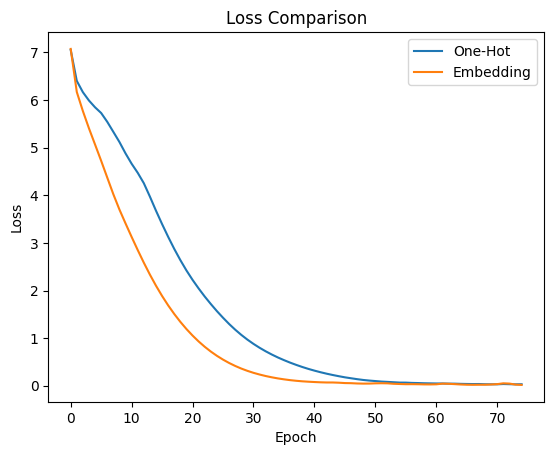

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses_onehot, label="One-Hot")
plt.plot(losses_embedding, label="Embedding")
plt.legend()
plt.title("Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### 3️⃣ Compare Text Quality
Generate sample text:

In [ ]:
print("One-Hot Generated Text:")
print(generate_text(model, "love", 20))

print("\nEmbedding Generated Text:")
print(generate_text_embedding(model_emb, "love", 20))

One-Hot Generated Text:
love me the same to be a few light who knows its own little birds in my heart the same to

Embedding Generated Text:
love that heaven be aware i follow who have been boys were tired my spirit of days and old time absolutely


# Advantages and Disadvantages of Each Approach

### One-Hot Encoding
#### ✅ Advantages

* Simple and easy to implement.
* No training required for word representation.
* Direct representation of vocabulary.
* Works well for very small datasets.

#### ❌ Disadvantages

* High dimensional vectors (size = vocabulary size).
* Very memory inefficient (sparse vectors).
* Slower training.
* Does not capture semantic similarity between words.
* Poor scalability for large vocabularies.

### Trainable Word Embeddings
#### ✅ Advantages

* Low-dimensional dense representation.
* Memory efficient.
* Faster training.
* Captures semantic relationships between words.
* Better text generation quality.
* Scales well to large vocabularies.

#### ❌ Disadvantages

* Requires additional training.
* Slightly more complex to implement.
* Needs more data to learn meaningful embeddings.